In [1]:
import numpy as np
import cupy as cp
import scipy as sp
import torch
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/batman/Documents/cs282a/proj/test_model/fastMRI')
from fastmri import fft2c, ifft2c, complex_abs, fft2c, rss
import torch.nn.functional as F
import torchvision.transforms.functional as FF

/home/batman/anaconda3/envs/fp8/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Load fastMRI image and fft with built in functions

torch.Size([12, 640, 320, 2])
img raw: torch.Size([12, 256, 256, 2]) kspace raw: torch.Size([12, 256, 256, 2])
torch.Size([256, 256]) torch.float32


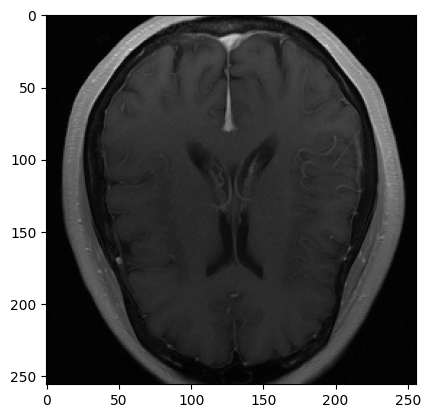

In [2]:
slice_path = '/data2/fastmri/brain/MC_brain'
kspace = torch.load(slice_path+'/test/5843.pt') # kspace: (num_coils, x, y, real/imag)
# kspace_real_resized = F.interpolate(kspace[...,0].unsqueeze(1), size=(256, 256), mode='bicubic')
# kspace_imag_resized = F.interpolate(kspace[...,1].unsqueeze(1), size=(256, 256), mode='bicubic')
# kspace_resized = torch.stack([kspace_real_resized.squeeze(1), kspace_imag_resized.squeeze(1)]).permute(1,2,3,0)
print(kspace.shape)
img_raw = ifft2c(kspace)
img_raw_reshape = FF.center_crop(img_raw.permute(3, 0, 1, 2), (256, 256)).permute(1, 2, 3, 0)
kspace_raw_reshape = fft2c(img_raw_reshape)
print("img raw:", img_raw_reshape.shape, 'kspace raw:', kspace_raw_reshape.shape)
img_cc = rss(complex_abs(img_raw_reshape))
plt.imshow(img_cc, cmap='gray')
print(img_cc.shape, img_cc.dtype)

#### manual fft in pytorch

In [ ]:
kspace = torch.fft.ifftshift(kspace_raw_reshape) # (num_coils, x, y, real/imag) float32
kspace_complex = torch.view_as_complex(kspace) # (num_coils, x, y) complex64
img_raw_unshift = torch.fft.ifftn(kspace_complex) # do fft here
img_raw = torch.fft.fftshift(img_raw_unshift) # shift in img space
plt.imshow(torch.abs(img_raw[0,:,:]), cmap='gray')

#### manual fft in numpy

In [ ]:
kspace = np.array(kspace_raw_reshape)
kspace = np.fft.ifftshift(kspace) # (num_coils, x, y, real/imag) float32
kspace_complex = kspace.view(np.complex64) # (num_coils, x, y) complex64
img_raw_unshift = np.fft.fftn(kspace_complex) # do fft here
img_raw = np.fft.fftshift(img_raw_unshift) # shift in img space
plt.imshow(np.abs(img_raw[0,:,:]), cmap='gray')

#### FFT with CUDA cores

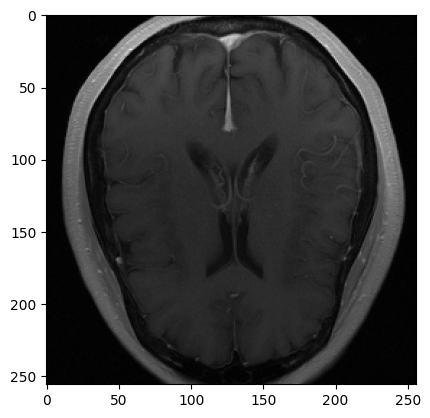

In [4]:
kspace = cp.array(kspace_raw_reshape)  # Transfer to GPU
kspace = cp.fft.ifftshift(kspace)  # (num_coils, x, y, real/imag) float32
kspace_complex = kspace.view(cp.complex64)  # (num_coils, x, y) complex64
img_raw_unshift = cp.fft.fftn(kspace_complex)  # do fft here
img_raw = cp.fft.fftshift(img_raw_unshift)  # shift in img space

# Transfer back to CPU for plotting
img_raw_cpu = cp.asnumpy(img_raw)
img_raw_cpu = np.sqrt(np.sum(np.abs(img_raw_cpu)**2, axis=0))
plt.imshow(np.abs(img_raw_cpu), cmap='gray')

#### FFT with Tensor Cores in FP16

(12, 256, 512) float16
(12, 256, 256, 2) float32


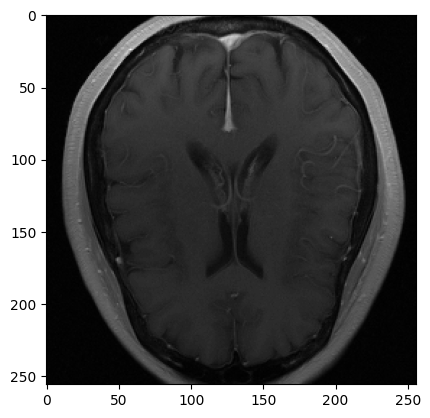

In [3]:
num_coils, h, w, _ = kspace_raw_reshape.shape
shape = (num_coils, h, w)

# first move to GPU and convert to fp16
kspace_gpu = cp.array(kspace_raw_reshape).astype(cp.float16)

# Apply ifftshift
kspace_shifted = cp.fft.ifftshift(kspace_gpu)

# data process input array for FFT plan
# Reshape to have real/imag as last dimension doubled
a = kspace_shifted.reshape(num_coils, h, 2*w)
out = cp.empty_like(a)

# create FFT plan
plan = cp.cuda.cufft.XtPlanNd(shape[1:],          # input shape
                        shape[1:],           # output shape
                        1,                   # batch stride
                        h*w,                # element stride
                        'E',                # input type (complex32)
                        shape[1:],          # output shape
                        1,                   # batch stride
                        h*w,                # element stride
                        'E',                # output type (complex32)
                        num_coils,          # batch size
                        'E',                # execution type
                        order='C',
                        last_axis=-1,
                        last_size=None)

# do FFT here
plan.fft(a, out, cp.cuda.cufft.CUFFT_FORWARD) # out here is fp16
print(out.shape, out.dtype)

out = out.astype(cp.float32)
# reshape back to original format
out = out.reshape(num_coils, h, w, 2)

print(out.shape, out.dtype)

# convert to complex-valued array
out_complex = out.view(cp.complex64)

# shift in img space
img = cp.fft.fftshift(out_complex)

img_fp16 = cp.asnumpy(img)
img_fp16 = np.sqrt(np.sum(np.abs(img_fp16)**2, axis=0))
plt.imshow(np.abs(img_fp16), cmap='gray')